In [3]:
%matplotlib inline

In [5]:
import dicom

D:\ProgramData\Anaconda3\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [7]:
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [8]:
import scipy.ndimage

In [9]:
from skimage import morphology
from skimage import measure
from skimage.transform import resize

In [10]:
from sklearn.cluster import KMeans

In [40]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *

In [41]:
init_notebook_mode(connected=True)

In [42]:
data_path = "../Data/_BZ/"

In [43]:
output_path = working_path = "../Vis_out/2/"

In [44]:
g = glob(data_path + '*.dcm')

In [45]:
print("Number of DICOM images: %d\nFirst 5 filenames:" % len(g))
print('\n'.join(g[:5]))

Number of DICOM images: 80
First 5 filenames:
../Data/_BZ\I00007671334.dcm
../Data/_BZ\I00007671335.dcm
../Data/_BZ\I00007671336.dcm
../Data/_BZ\I00007671337.dcm
../Data/_BZ\I00007671338.dcm


# Loop over image files and store everything in a list
load_scan will load all DICOM images from a folder into a list for manipulation

In [46]:
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    
    return slices

get_pixels_hu() converts raw values into Hounsfield units (https://en.wikipedia.org/wiki/Hounsfield_scale)

HUs are useful because they are standardised across all CT scans regardless of absolute number of photons that the scanner detector captured.

This transformation is linear, hence, as long as we have a slope and an intercept, we can rescale a voxel value to HU.

Both rescale intercept and rescale slope are stored in the DICOM header at the time of image acquisition (scanner dependent values, need external information)

In [47]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16 (we know our data is already int16))
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    
    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
    
    image += np.int16(intercept)
    return np.array(image, dtype=np.int16)

In [48]:
id=2
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)

Saving data to prevent reprocessing every time

In [50]:
np.save(output_path + "fullimages_%d.npy" % (id), imgs)

# Checking images by displaying

### Checking whether Hounsfield units are properly scaled and represented

Includes all slices 

In [51]:
file_used = output_path + "fullimages_%d.npy" % id
imgs_to_process = np.load(file_used).astype(np.float64)

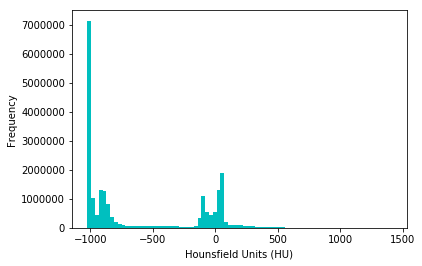

In [52]:
plt.hist(imgs_to_process.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

Lots of empty space(-1000), some volume, Some fat (-120 to -90), Lung volume (-700 to -600), Sees a little bit of other organs as well for some reason(Probably noise), small amounts of bone (200, 700) 
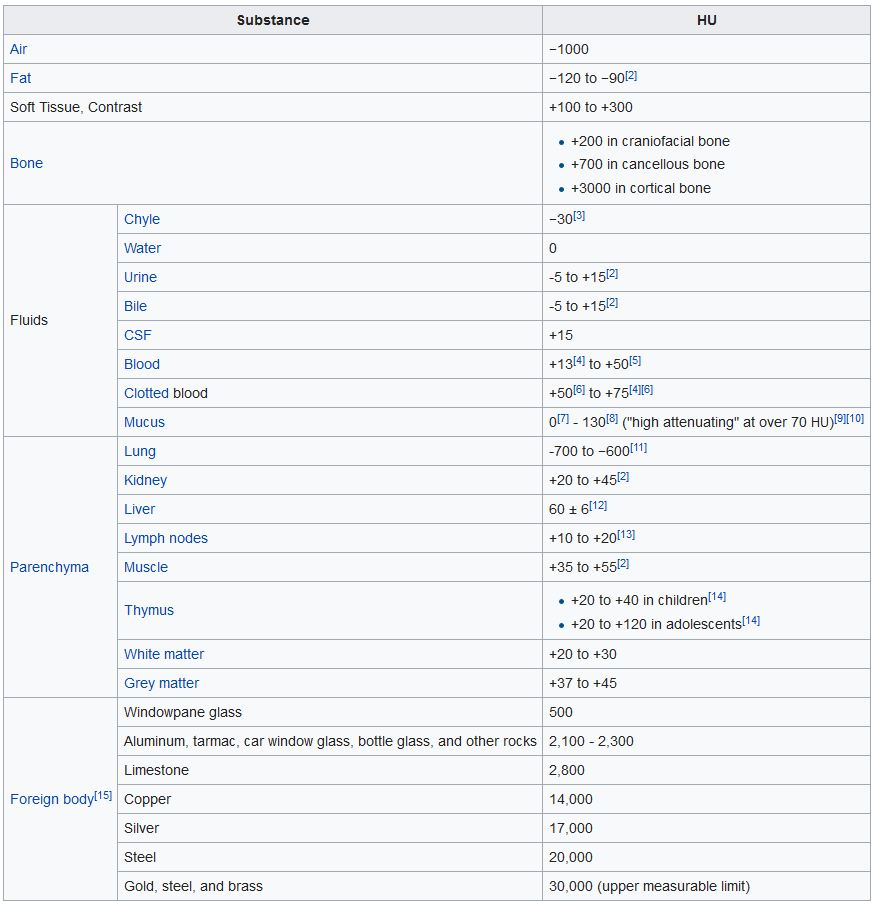

### Visualising the image stack

In [53]:
id = 2
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

In [54]:
def sample_stack(stack, rows=6, cols=6, start_with=6, show_every=2):
    fig, ax = plt.subplots(rows, cols, figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows), int(i%rows)].set_title('slice %d' % ind)
        ax[int(i/rows), int(i%rows)].imshow(stack[ind], cmap='gray')
        ax[int(i/rows), int(i%rows)].axis('off')
    plt.show()

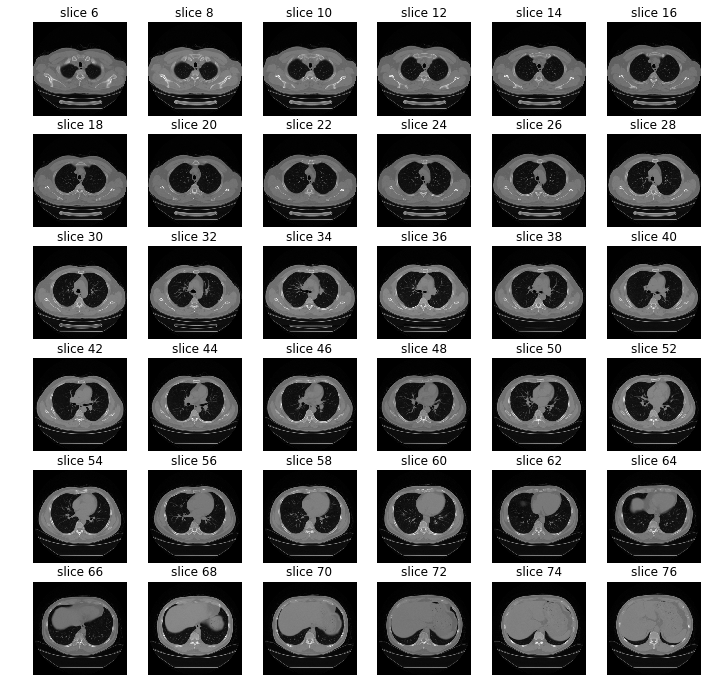

In [55]:
sample_stack(imgs_to_process)

# Resampling and normalization to preprocess for segmentation

### Resampling

In [56]:
print("Slice Thickness: %f" % patient[0].SliceThickness)
print("Pixel Spacing (row, col): (%f, %f)" % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))

Slice Thickness: 0.000000
Pixel Spacing (row, col): (0.791016, 0.791016)


Setting slice thickness to 2.5 mm

In [57]:
patient[0].SliceThickness = 2.5

In [58]:
print("Slice Thickness: %f" % patient[0].SliceThickness)
print("Pixel Spacing (row, col): (%f, %f)" % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))

Slice Thickness: 2.500000
Pixel Spacing (row, col): (0.791016, 0.791016)


In [60]:
id = 2
imgs_to_process = np.load(output_path + 'fullimages_{}.npy'.format(id))

In [61]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determining current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))
    
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

In [62]:
print("Shape before resampling\t", imgs_to_process.shape)

Shape before resampling	 (80, 512, 512)


In [63]:
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])

In [64]:
print("Shape after resampling\t", imgs_after_resamp.shape)

Shape after resampling	 (200, 405, 405)


# 3D Plotting

In [65]:
def make_mesh(image, threshold=300, step_size=1):
    print("Transposing surface")
    p = image.transpose(2,1,0)
    
    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes(p, threshold,
                                                     step_size=step_size,
                                                     allow_degenerate=True)
    
    return verts, faces

### Using matplotlib

Uses marching cube algorithm to generate 3D model from the dataset

In [68]:
def plt_3d(verts, faces):
    print("Drawing")
    x,y,z = zip(*verts)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Fancy indexing: verts[faces] to generatea collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=0.8)
    face_color = [0.1, 0.1, 0.1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    
    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    ax.set_facecolor((0.625, 0.625, 0.625))
    plt.show()

In [ ]:
v, f = make_mesh(imgs_after_resamp, -900)
plt_3d(v, f)

Transposing surface
Calculating surface
Drawing


### Using plotly

In [34]:
def plotly_3d(verts, faces):
    x,y,z = zip(*verts)
    print("Drawing")
    colormap=['rgb(236,236,212)', 'rgb(236,236,212)']
    fig = FF.create_trisurf(x=x, 
                           y=y, 
                           z=z,
                           plot_edges = False,
                           colormap = colormap,
                           simplices = faces,
                           backgroundcolor = 'rgb(64, 64, 64)',
                           title = "Interactive Visualization")
    iplot(fig)

In [1]:
v, f = make_mesh(imgs_after_resamp, -900, 2)
plotly_3d(v, f)

NameError: name 'make_mesh' is not defined

# Segmentation of lungs

## 5 steps for creating mask for lung fields:
### 1. Standardize pixel value by subtracting mean and dividing by standard deviation'
### 2. Identify threshold by using 2 KMeans clusters centered on soft tissue/bone vs lung/air
### 3. Erosion and Dilation for removing noise and pulmonary vessels
### 4. Identify each distinct region as separate image labels
### 5. Bounding box for each image label to identify which ones represent lung and which ones are everything else

In [105]:
def make_lungmask(img, display=False):
    row_size = img.shape[0]
    col_size = img.shape[1]
    
    # Step 1
    #print("Step 1")
    mean = np.mean(img)
    std = np.std(img)
    img = img - mean
    img = img / std
    
    # Step 2
    #print("Step 2")
    # middle finds average pixel values near lungs to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4), int(row_size/5):int(row_size/5*4)]
    mean = np.mean(middle)
    max = np.max(img)
    min = np.min(img)
    # moving underflow and overflow on pixel spectrum to improve threshold finding
    img[img==max] = mean
    img[img==min] = mean
    # KMeans to separate foreground (soft tissue/bone) and background (lung/air)
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle, [np.prod(middle.shape), 1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold, 1.0, 0.0) # Thresholding the image
    
    # Step 3
    #print("Step 3")
    # First eroding finer elements, then dilating to include some pixels surrounding lungs
    eroded = morphology.erosion(thresh_img, np.ones([3, 3]))
    dilation = morphology.dilation(eroded, np.ones([8, 8]))
    
    # Step 4
    #print("Step 4")
    # Different labels are displayed in different colors
    labels = measure.label(dilation)
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    
    # Step 5
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0] < row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size], dtype=np.int8)
    mask[:] = 0
    
    # Only lungs are left, we perform another large dilation in order to fill in and out the lung mask
    for N in good_labels:
        mask = mask + np.where(labels==N, 1, 0)
    mask = morphology.dilation(mask, np.ones([10, 10]))
    
    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

## Checking mask on slice 3/4th of the way to the end

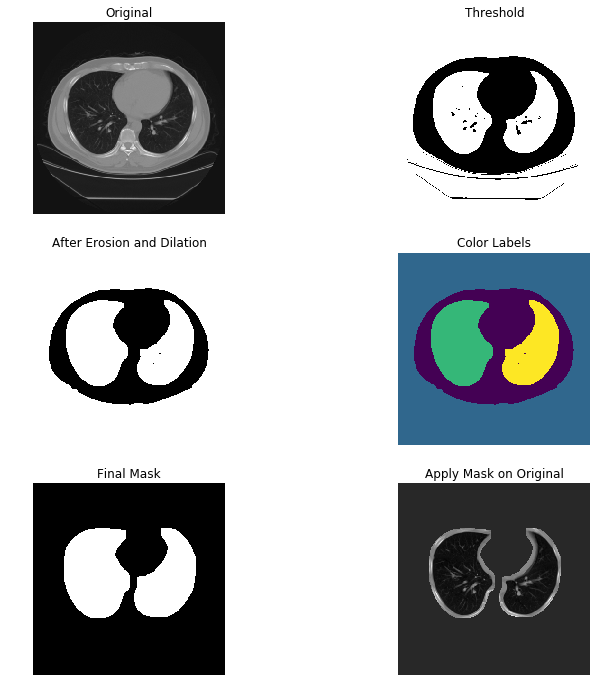

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])

In [106]:
img = imgs_after_resamp[150]
make_lungmask(img, display=True)

## Applying mask to all slices

In [110]:
from tqdm import tqdm, tnrange
masked_lung = []
for img in tqdm(imgs_after_resamp):
    masked_lung.append(make_lungmask(img))

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:23<00:00,  8.42it/s]


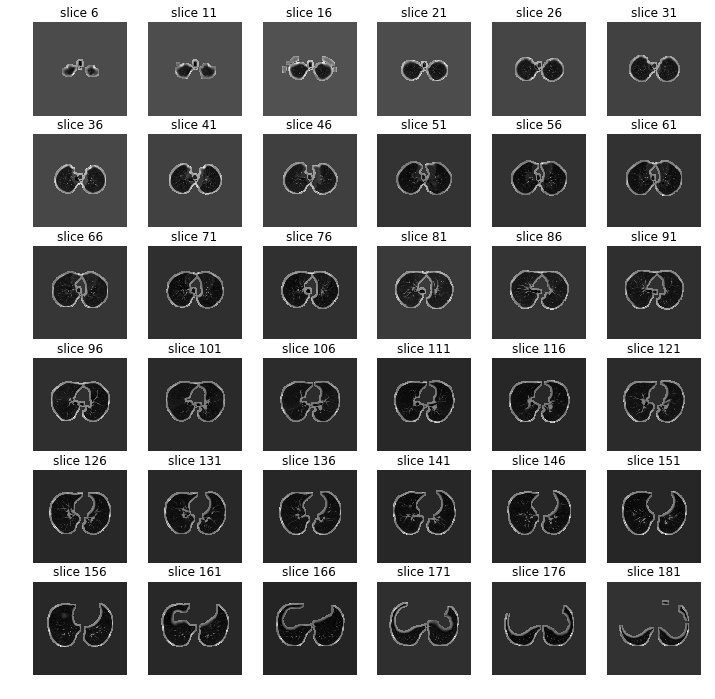

In [115]:
sample_stack(masked_lung, show_every=5)

In [109]:
np.save(output_path + 'masked_lung_%d.npy' % (id), imgs)

In [118]:
import plotly.graph_objs as go
import plotly.plotly as ply

In [123]:
m_l = np.load('../Vis_out/masked_lung_0.npy')

In [133]:
mask_x,mask_y,mask_z = zip(*m_l)

ValueError: too many values to unpack (expected 3)

In [128]:
m_l.shape

(80, 512, 512)

In [ ]:
mask_trace = go.Mesh3d(x=mask_x,y=mask_y,z=mask_z,color='#FFB6C1',opacity=0.50)
ply.iplot([mask_trace])